In [ ]:
import numpy as np
np.random.seed(69)
import pandas as pd
import tensorflow as tf
from functools import reduce
import json
import os
import re
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import concatenate, LSTM, GRU, Dense, Input, Dropout, TimeDistributed, Embedding
from keras.layers import BatchNormalization

from keras.models import Model
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

In [ ]:
# LPH = Label, Premise, Hypothesis
def getLPH(fileName):
  l = []
  for _, line in enumerate(open(fileName)):
    jsonData = json.loads(line)
    label = jsonData['gold_label']
    getToks = lambda s: ' '.join(s.replace('(', ' ').replace(')', ' ').replace('-LRB-', '(').replace('-RRB-', ')').lower().split())
    p = "<s> " + getToks(jsonData['sentence1_binary_parse'])
    h = "<s> " + getToks(jsonData['sentence2_binary_parse'])

    if label == '-':
      continue

    l.append((label, p, h))
  return l

def get_data(fileName):
  data = getLPH(fileName=fileName)
  Ps = [x[1] for x in data]
  Hs = [x[2] for x in data]

  LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
  Y = np.array([LABELS[x[0]] for x in data])
  Y = np_utils.to_categorical(Y, len(LABELS))

  return Ps, Hs, Y

In [ ]:
RNN = None
LAYERS = 1
USE_GLOVE = True
TRAIN_EMBED = False
EMBED_HIDDEN_SIZE = 300
SENT_HIDDEN_SIZE = 300
BATCH_SIZE = 32
PATIENCE = 2
MAX_EPOCHS = 10
MAX_LEN = 42
DP = 0.2
L2 = 4e-6
ACTIVATION = 'softmax'
OPTIMIZER = 'rmsprop'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
training = get_data('/content/drive/MyDrive/NLP_Project/snli_1.0/snli_1.0_train.jsonl')
validation = get_data('/content/drive/MyDrive/NLP_Project/snli_1.0/snli_1.0_dev.jsonl')
test = get_data('/content/drive/MyDrive/NLP_Project/snli_1.0/snli_1.0_test.jsonl')

tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(training[0] + training[1])

VOCAB = len(tokenizer.word_counts) + 1
LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}

to_seq = lambda X: pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_LEN)
prepare_data = lambda data: (to_seq(data[0]), to_seq(data[1]), data[2])

training = prepare_data(training)
validation = prepare_data(validation)
test = prepare_data(test)

In [ ]:
GLOVE_STORE = '/content/drive/MyDrive/NLP_Project/Glove-Embeddings/glove_embeddings'
if USE_GLOVE:
  if not os.path.exists(GLOVE_STORE + '.npy'):
    print('Computing GloVe')
  
    embeddings_index = {}
    f = open('./GloVe-Embeddings/glove.840B.300d.txt')
    for line in f:
      values = line.split(' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    f.close()
    
    # prepare embedding matrix
    embedding_matrix = np.zeros((VOCAB, EMBED_HIDDEN_SIZE))
    for word, i in tokenizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
      else:
        print('Missing from GloVe: {}'.format(word))
  
    np.save(GLOVE_STORE, embedding_matrix)

  print('Loading GloVe')
  embedding_matrix = np.load(GLOVE_STORE + '.npy')

  print('Total number of null word embeddings:')
  print(np.sum(np.sum(embedding_matrix, axis=1) == 0))

  embed = Embedding(VOCAB, EMBED_HIDDEN_SIZE, weights=[embedding_matrix], input_length=MAX_LEN, trainable=TRAIN_EMBED)
else:
  embed = Embedding(VOCAB, EMBED_HIDDEN_SIZE, input_length=MAX_LEN)

Loading GloVe
Total number of null word embeddings:
4021


In [ ]:
rnn_kwargs = dict(units=SENT_HIDDEN_SIZE, dropout=DP, recurrent_dropout=DP)
SumEmbeddings = keras.layers.core.Lambda(lambda x: K.sum(x, axis=1), output_shape=(SENT_HIDDEN_SIZE, ))

translate = TimeDistributed(Dense(SENT_HIDDEN_SIZE, activation=ACTIVATION))

premise = Input(shape=(MAX_LEN,), dtype='int32')
hypothesis = Input(shape=(MAX_LEN,), dtype='int32')

prem = embed(premise)
hypo = embed(hypothesis)

prem = translate(prem)
hypo = translate(hypo)

if RNN and LAYERS > 1:
  for l in range(LAYERS - 1):
    rnn = RNN(return_sequences=True, **rnn_kwargs)
    prem = BatchNormalization()(rnn(prem))
    hypo = BatchNormalization()(rnn(hypo))
rnn = SumEmbeddings if not RNN else RNN(return_sequences=False, **rnn_kwargs)
prem = rnn(prem)
hypo = rnn(hypo)
prem = BatchNormalization()(prem)
hypo = BatchNormalization()(hypo)

In [ ]:
joint = keras.layers.concatenate([prem, hypo])
joint = Dropout(DP)(joint)
for i in range(3):
  joint = Dense(2 * SENT_HIDDEN_SIZE, activation=ACTIVATION, kernel_regularizer=l2(L2) if L2 else None)(joint)
  joint = Dropout(DP)(joint)
  joint = BatchNormalization()(joint)

pred = Dense(len(LABELS), activation='softmax')(joint)

model = Model(inputs=[premise, hypothesis], outputs=pred)
model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

fn='/content/drive/MyDrive/NLP_Project/checkpoints/RNN-softmax/RNN-softmax'
# Save the best model during validation and bail out of training early if we're not improving
callbacks = [EarlyStopping(patience=PATIENCE), ModelCheckpoint(filepath=fn, save_best_only=True, save_weights_only=True, monitor='val_accuracy')]
model.fit([training[0], training[1]], training[2], batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_data=([validation[0], validation[1]], validation[2]), callbacks=callbacks)
model.save('/content/drive/MyDrive/NLP_Project/models/RNN-softmax.h5')

# Restore the best found model during validation
model.load_weights('/content/drive/MyDrive/NLP_Project/models/RNN-softmax.h5')

loss, acc = model.evaluate([test[0], test[1]], test[2], batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 300)      10909200    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 time_distributed (TimeDistribu  (None, 42, 300)     90300       ['embedding[0][0]',          

In [ ]:
def analysis_statistics(model, test_data, y_test, accuracy):
  test_pred = model.predict(test_data)

  encoded_list_y_test = []
  for val in y_test:
    idx = np.argmax(val)
    encoded_list_y_test.append(idx+1)
  encoded_list_y_test
  
  encoded_list_test_pred = []
  for val in test_pred:
    idx = np.argmax(val)
    encoded_list_test_pred.append(idx+1)
  encoded_list_test_pred

  confusion_1 = metrics.confusion_matrix(encoded_list_y_test,encoded_list_test_pred)

  plt.figure(figsize=(9,9))
  sns.heatmap(confusion_1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0:.3g}'.format(accuracy)
  plt.title(all_sample_title, size = 15);
  
  print(classification_report(encoded_list_y_test, encoded_list_test_pred))

307/307 [==============================] - 10s 32ms/step
              precision    recall  f1-score   support

           1       0.82      0.67      0.74      3237
           2       0.74      0.62      0.68      3219
           3       0.66      0.88      0.75      3368

    accuracy                           0.73      9824
   macro avg       0.74      0.72      0.72      9824
weighted avg       0.74      0.73      0.72      9824



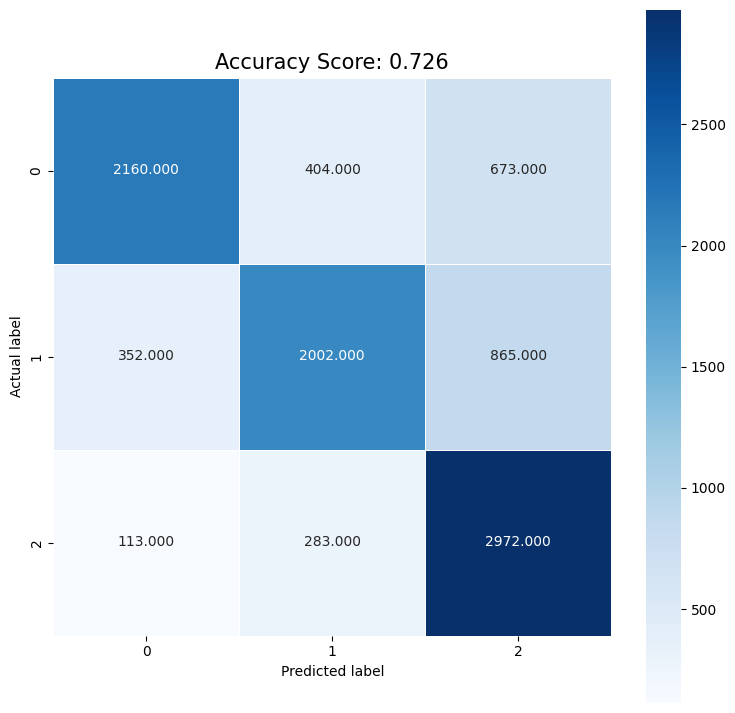

In [ ]:
analysis_statistics(model, [test[0],test[1]], test[2], acc)